In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline
import pymc3 as pm

In [11]:
#import data of layer ratio from Cambay
filename = '/home/julien/OneDrive/Doctorat/spatialVariability/Snowpits_Cambay/ratio_WS_DH_snowpit2015.csv'
df_cb15 = pd.read_csv(filename)
filename = '/home/julien/OneDrive/Doctorat/spatialVariability/Snowpits_Cambay/ratio_WS_DH_snowpit2016.csv'
df_cb16 = pd.read_csv(filename)
filename = '/home/julien/OneDrive/Doctorat/spatialVariability/Snowpits_Cambay/ratio_WS_DH_snowpit2017.csv'
df_cb17 = pd.read_csv(filename)
filename = '/home/julien/OneDrive/Doctorat/spatialVariability/Snowpits_Cambay/ratio_WS_DH_snowpit2018_NDVI_Sx.csv'
df_cb18 = pd.read_csv(filename)
filename = '/home/julien/OneDrive/Doctorat/spatialVariability/Snowpits_Cambay/ratio_WS_DH_snowpit2019_NDVI_Sx.csv'
df_cb19 = pd.read_csv(filename)

# TVC data
filename = '/home/julien/OneDrive/Doctorat/spatialVariability/Ratio_TVC/ratio_layer_TVC_March2018_strat_update_NDVI_TPI.csv'
df_tvc18 = pd.read_csv(filename)
filename = '/home/julien/OneDrive/Doctorat/spatialVariability/Ratio_TVC/ratio_layer_TVC_March2019_strat_update_NDVI_TPI.csv'
df_tvc19 = pd.read_csv(filename)

In [12]:
pit_CB15 = len(df_cb15['thickness'])
pit_CB16 = len(df_cb16['thickness'])
pit_CB17 = len(df_cb17['thickness'])
pit_CB18 = len(df_cb18['thickness'])
pit_CB19 = len(df_cb19['thickness'])
print(f'Number of snowpits, 2015 : {pit_CB15}, 2016 : {pit_CB16}, 2017 : {pit_CB17}, 2018 : {pit_CB18}, 2019 : {pit_CB19}')


pit_TVC18 = len(df_tvc18['total_depth (cm)'])
pit_TVC19 = len(df_tvc19['total_depth (cm)'])
print(f'Number of snowpits, 2018 : {pit_TVC18}, 2019 : {pit_TVC19}')

Number of snowpits, 2015 : 48, 2016 : 35, 2017 : 51, 2018 : 50, 2019 : 64
Number of snowpits, 2018 : 22, 2019 : 32


In [13]:
X_cb = df_cb15['thickness'].append(df_cb16['thickness']).append(df_cb17['thickness']).append(df_cb18['thickness']).append(df_cb19['thickness'])/100
X_tvc = df_tvc18['total_depth (cm)'].append(df_tvc19['total_depth (cm)'])/100
Y_DH_cb = df_cb15['% DH'].append(df_cb16['% DH']).append(df_cb17['% DH']).append(df_cb18['% DH']).append(df_cb19['% DH'])
Y_DH_tvc = df_tvc18['DH'].append(df_tvc19['DH'])

print('Cambay')
print(f'mean DH in CB : {np.mean(Y_DH_cb)} with mean thickness : {np.mean(X_cb)}')
print('TVC')
print(f'mean DH in TVC : {np.mean(Y_DH_tvc)} with mean thickness : {np.mean(X_tvc)}')

Cambay
mean DH in CB : 0.3807369725820081 with mean thickness : 0.36612903225806454
TVC
mean DH in TVC : 0.5444478224917436 with mean thickness : 0.3577777777777778


In [14]:
X = df_cb15['thickness'].append(df_cb16['thickness']).append(df_cb17['thickness']).append(df_cb18['thickness']).append(df_cb19['thickness']).append(df_tvc18['total_depth (cm)']).append(df_tvc19['total_depth (cm)'])/100
Y_DH = df_cb15['% DH'].append(df_cb16['% DH']).append(df_cb17['% DH']).append(df_cb18['% DH']).append(df_cb19['% DH']).append(df_tvc18['DH']).append(df_tvc19['DH'])
Y_WS = df_cb15['% WS'].append(df_cb16['% WS']).append(df_cb17['% WS']).append(df_cb18['% WS']).append(df_cb19['% WS']).append(df_tvc18['WS']).append(df_tvc19['WS'])

#removing NaN
df = pd.DataFrame({'x' : X, 'y_DH' : Y_DH, 'y_WS' : Y_WS})
df = df.drop(df[np.isnan(df.y_DH) == True ].index)
df.y_DH[df.y_DH == 0] =0.01
df.y_DH[df.y_DH == 1] =0.99

In [15]:
from scipy.stats import binned_statistic
df_CB = df_cb15.append(df_cb16).append(df_cb17).append(df_cb18).append(df_cb19)
df_CB = df_CB.drop(df_CB[np.isnan(df_CB['% DH']) == True ].index)
df_tvc = df_tvc18.append(df_tvc19)
df_tvc = df_tvc.drop(df_tvc[np.isnan(df_tvc['DH']) == True ].index)

#separating depth in bin for mean line of DH
bin_mean_cb = binned_statistic(x = df_CB.thickness/100, values = df_CB['% DH'], bins = 10, statistic = 'mean')
x_bin_cb = bin_mean_cb.bin_edges[:-1] + (bin_mean_cb.bin_edges[1]-bin_mean_cb.bin_edges[0])/2
bin_mean_tvc = binned_statistic(x = df_tvc['total_depth (cm)']/100, values = df_tvc['DH'], bins = 7, statistic = 'mean')
x_bin_tvc = bin_mean_tvc.bin_edges[:-1] + (bin_mean_tvc.bin_edges[1]-bin_mean_tvc.bin_edges[0])/2

bin_mean = binned_statistic(x = df.x, values = df['y_DH'], bins = 15, statistic = 'mean')
bin_std = binned_statistic(x = df.x, values = df['y_DH'], bins = 15, statistic = 'std')
x_bin = bin_mean.bin_edges[:-1] + (bin_mean.bin_edges[1]-bin_mean.bin_edges[0])/2

def logistic(x, a, x0, c, d):
    # a is the slope, x0 is the location
    return d * pm.math.invlogit(a*(x - x0)) + c
x_l = np.linspace(0, 1.2, 100)
logit_cb = logistic(x_l, a= -5, x0 = 0.6, c = 0.2, d = 0.3).eval()
logit_tvc = logistic(x_l, a= -5, x0 = 0.7, c = 0.2, d = 0.4).eval()
logit_all = logistic(x_l, a= -5, x0 = 0.6, c = 0.2, d = 0.35).eval()

/home/julien/anaconda3/envs/bayes/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


 mean DH : 0.4104060287119939, mean WS : 0.5632614976211008, mean thick : 0.36418604651162795 ± 0.1804896034350935
 mean DH CB 0.38073697258200817, std : 0.18934448015811248
 mean DH CB 0.5444478224917436, std : 0.16363570658048615


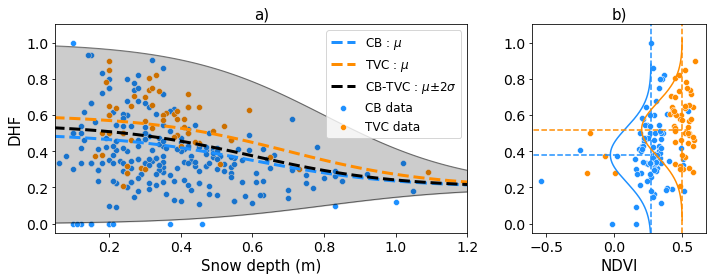

In [39]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

mean_DH = np.mean(df.y_DH)
mean_WS = np.mean(df.y_WS)
mean_thick = np.mean(df.x)
std_thick = np.std(df.x)
print(f' mean DH : {mean_DH}, mean WS : {mean_WS}, mean thick : {mean_thick} ± {std_thick}')

x = np.arange(0,120,10)
y_med_DH = np.ones(len(x)) * 0.3
y_med_WS = np.ones(len(x)) * 0.7

fig = plt.figure(figsize = (10,4))
#Define axes
ax1 = plt.subplot2grid((2,3), (0,0), colspan = 2,rowspan = 2)
ax2 = plt.subplot2grid((2,3), (0,2), colspan = 1,rowspan = 2)
ax2.get_shared_y_axes().join(ax1, ax2)
#ax2.set_yticklabels([])
ax2.set_ylabel('  ')

ax1.tick_params(labelsize = 14)
ax2.tick_params(labelsize = 14)

ax1.set_title('a)', size = 15)
#plt.title('a) Depth Hoar percentage', size = 15)
sns.scatterplot(y = df_cb15['% DH'], x = df_cb15['thickness']/100, color = 'dodgerblue', ax = ax1)
sns.scatterplot(y = df_cb16['% DH'], x = df_cb16['thickness']/100, color = 'dodgerblue', ax = ax1)
sns.scatterplot(y = df_cb17['% DH'], x = df_cb17['thickness']/100, color = 'dodgerblue', ax = ax1)
sns.scatterplot(y = df_cb18['% DH'], x = df_cb18['thickness']/100, color = 'dodgerblue', ax = ax1)
sns.scatterplot(y = df_cb19['% DH'], x = df_cb19['thickness']/100, color = 'dodgerblue', label = 'CB data', ax = ax1)
sns.scatterplot(y = df_tvc18['DH'], x = df_tvc18['total_depth (cm)']/100, color = 'darkorange', ax = ax1)
sns.scatterplot(y = df_tvc19['DH'], x = df_tvc19['total_depth (cm)']/100, color = 'darkorange', label = 'TVC data', ax = ax1)
#plt.plot(x_bin_tvc, bin_mean_tvc.statistic, color = 'darkorange', linestyle = '--', linewidth = 3)
#plt.plot(x_bin_cb, bin_mean_cb.statistic, color = 'dodgerblue', linestyle = '--', linewidth = 3)
#plt.plot(x_bin, bin_mean.statistic, color = 'black', linestyle = '--', label = 'mean', linewidth = 3)
ax1.plot(x_l, logit_cb, color = 'dodgerblue', linestyle = '--', linewidth = 3, label = 'CB : $\mu$')
ax1.plot(x_l, logit_tvc, color = 'darkorange', linestyle = '--', linewidth = 3, label = 'TVC : $\mu$')
ax1.plot(x_l, logit_all, color = 'black', linestyle = '--', linewidth = 3, label = 'CB-TVC : $\mu ± 2\sigma$')

#plot variance of bin mean

# top_sig = bin_mean.statistic + 2*bin_std.statistic
# btm_sig = bin_mean.statistic - 2*bin_std.statistic
# plt.plot(x_bin, top_sig, 'black', lw=1, alpha = 0.5)
# plt.plot(x_bin, btm_sig, 'black', lw=1, alpha = 0.5);
# plt.fill_between(x_bin, top_sig, btm_sig, color="black", alpha=0.2)

logit_top = logistic(x_l, a= -5, x0 = 0.8, c = 0.2, d = 0.8).eval()
logit_btm = logistic(x_l, a= 5, x0 = 0.8, c = 0.0, d = 0.2).eval()
ax1.plot(x_l, logit_top, 'black', lw=1, alpha = 0.5)
ax1.plot(x_l, logit_btm, 'black', lw=1, alpha = 0.5);
ax1.fill_between(x_l, logit_top, logit_btm, color="black", alpha=0.2)

ax1.set_xlabel('Snow depth (m)', size = 15)
ax1.set_xlim(0.05,1.2)
ax1.set_ylim(-.05,1.1)
ax1.set_ylabel('DHF', size = 15)
#ax1.plot(x,y_med_DH, color ='black', linestyle = '--')
ax1.legend(prop={'size': 12})


def draw_gaussian_at(support, sd=1.0, height=1.0, 
        xpos=0.0, ypos=0.0, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    gaussian = np.exp((-support ** 2.0) / (2 * sd ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= height
    return plt.plot(gaussian + xpos, support + ypos, **kwargs)

m_dh, std_dh = np.mean(df_CB['% DH']), np.std(df_CB['% DH'])
print(f' mean DH CB {m_dh}, std : {std_dh}' )         
m_dh, std_dh = np.mean(df_tvc['DH']), np.std(df_tvc['DH'])
print(f' mean DH CB {m_dh}, std : {std_dh}' )  

#ax = plt.subplot(2,2,2)
#ax = plt.figure(figsize = (12,4))
ax2.set_title('b)', size = 15)
sns.scatterplot(y = df_cb18['% DH'], x = df_cb18['NDVI_mean'], color = 'dodgerblue', label = 'CB 18-19', ax = ax2)
sns.scatterplot(y = df_cb19['% DH'], x = df_cb19['NDVI_mean'], color = 'dodgerblue', ax = ax2)
sns.scatterplot(y = df_tvc18['DH'], x = df_tvc18['NDVI_mean'], color = 'darkorange', label = 'TVC 18-19', ax = ax2)
sns.scatterplot(y = df_tvc19['DH'], x = df_tvc19['NDVI_mean'], color = 'darkorange', ax = ax2)
plt.xlabel('NDVI', size = 15)
#plt.xticks(size =12)
#plt.yticks(size =15)
#plt.ylabel('Ratio DH', size = 15)
ax2.legend([],[], frameon=False)
support = np.linspace(-0.5,0.5, 1000)
draw_gaussian_at(support, sd= 0.15, height = -0.3, xpos=0.27, ypos=0.38, ax=ax2, color='dodgerblue')
ax2.axvline(x = 0.27, ymin = 0, ymax = 1, color = 'dodgerblue', linestyle = '--')
ax2.axhline(y = 0.38, xmin = -0.5, xmax = 0.7, color = 'dodgerblue', linestyle = '--')
draw_gaussian_at(support, sd= 0.15, height = -0.3, xpos=0.5, ypos=0.52, ax=ax2, color='darkorange')
ax2.axvline(x = 0.5, ymin = 0, ymax = 1, color = 'darkorange', linestyle = '--')
ax2.axhline(y = 0.52, xmin = -0.5, xmax = 0.9, color = 'darkorange', linestyle = '--')
plt.subplots_adjust(wspace = 0.05)
fig.savefig("/home/julien/OneDrive/Doctorat/spatialVariability/article/fig/fig_cryo/fig05.png", dpi = 300)

 mean DH CB 0.38073697258200817, std : 0.18934448015811248
 mean DH CB 0.5444478224917436, std : 0.16363570658048615


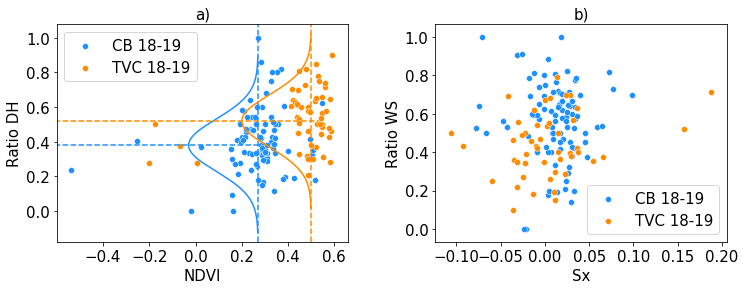

In [17]:
def draw_gaussian_at(support, sd=1.0, height=1.0, 
        xpos=0.0, ypos=0.0, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    gaussian = np.exp((-support ** 2.0) / (2 * sd ** 2.0))
    gaussian /= gaussian.max()
    gaussian *= height
    return plt.plot(gaussian + xpos, support + ypos, **kwargs)

m_dh, std_dh = np.mean(df_CB['% DH']), np.std(df_CB['% DH'])
print(f' mean DH CB {m_dh}, std : {std_dh}' )         
m_dh, std_dh = np.mean(df_tvc['DH']), np.std(df_tvc['DH'])
print(f' mean DH CB {m_dh}, std : {std_dh}' )  


ax = plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.title('a)', size = 15)
sns.scatterplot(y = df_cb18['% DH'], x = df_cb18['NDVI_mean'], color = 'dodgerblue', label = 'CB 18-19')
sns.scatterplot(y = df_cb19['% DH'], x = df_cb19['NDVI_mean'], color = 'dodgerblue')
sns.scatterplot(y = df_tvc18['DH'], x = df_tvc18['NDVI_mean'], color = 'darkorange', label = 'TVC 18-19')
sns.scatterplot(y = df_tvc19['DH'], x = df_tvc19['NDVI_mean'], color = 'darkorange')
plt.xlabel('NDVI', size = 15)
plt.xticks(size =15)
plt.yticks(size =15)
plt.ylabel('Ratio DH', size = 15)
plt.legend(prop = {'size' : 15})
support = np.linspace(-0.5,0.5, 1000)
draw_gaussian_at(support, sd= 0.15, height = -0.3, xpos=0.27, ypos=0.38, ax=ax, color='dodgerblue')
plt.axvline(x = 0.27, ymin = 0, ymax = 1, color = 'dodgerblue', linestyle = '--')
plt.axhline(y = 0.38, xmin = -0.5, xmax = 0.7, color = 'dodgerblue', linestyle = '--')
draw_gaussian_at(support, sd= 0.15, height = -0.3, xpos=0.5, ypos=0.52, ax=ax, color='darkorange')
plt.axvline(x = 0.5, ymin = 0, ymax = 1, color = 'darkorange', linestyle = '--')
plt.axhline(y = 0.52, xmin = -0.5, xmax = 0.9, color = 'darkorange', linestyle = '--')

plt.subplot(1,2,2)
plt.title('b)', size = 15)
sns.scatterplot(y = df_cb18['% WS'], x = df_cb18['Sx_mean'], color = 'dodgerblue', label = 'CB 18-19')
sns.scatterplot(y = df_cb19['% WS'], x = df_cb19['Sx_mean'], color = 'dodgerblue')
sns.scatterplot(y = 1 - df_tvc18['DH'], x = df_tvc18['Sx_270_mean'], color = 'darkorange')
sns.scatterplot(y = 1 - df_tvc19['DH'], x = df_tvc19['Sx_270_mean'], color = 'darkorange', label = 'TVC 18-19')
plt.xlabel('Sx', size = 15)
plt.xticks(size =15)
plt.yticks(size =15)
plt.ylabel('Ratio WS', size = 15)
plt.legend(prop = {'size' : 15})

plt.subplots_adjust(wspace = 0.3)

In [18]:
import theano.tensor as tt
import pymc3 as pm

class InvLogit(pm.gp.mean.Mean):
    """
    InvLogit function for Gaussian process. Customn Mean function
    """

    def __init__(self, a, x0, c, d):
        pm.gp.mean.Mean.__init__(self)
        self.a = a
        self.x0 = x0
        self.c = c
        self.d = d

    def __call__(self, X):
        return tt.squeeze(self.d * pm.math.invlogit(self.a*(X - self.x0)) + self.c)
    
X = np.linspace(0, 2, 10)[:,None]

mean_func = InvLogit(a = -5, x0 = 0.5, c = 0.3, d = 0.3)
print(type(mean_func))
print(mean_func(X).eval())

<class '__main__.InvLogit'>
[0.57724255 0.54012444 0.4707004  0.39088221 0.33754812 0.31349347
 0.30458015 0.30152335 0.30050319 0.30016583]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f_rotated_, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.


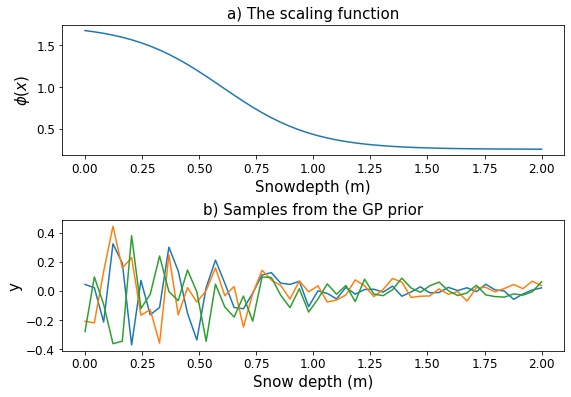

In [31]:

with pm.Model() as gp_model:
    
    # Specify the covariance function.
    #mean_func = Constant(c = 0.3)
    mean_func = InvLogit(a = -5, x0 = 0.5, c = 0.2, d = 0.35)
    #mean_func = pm.gp.mean.Constant(0.3)
    #mean_func = pm.gp.mean.Linear(coeffs=-0.2, intercept=0.5)
    
    def logistic(x, a, x0, c, d):
        # a is the slope, x0 is the location
        return d * pm.math.invlogit(a*(x - x0)) + c
    a = -5.0
    x0 = 0.6
    c = 0.25
    d = 1.5
    

    sigma = pm.HalfNormal('sigma', sd =0.1)
    cov_base = pm.gp.cov.WhiteNoise(0.15)
    cov_func = pm.gp.cov.ScaledCov(1, scaling_func=logistic, args=(a,x0,c,d), cov_func=cov_base)
    
    X = np.linspace(0, 2, 50)[:,None]
    lfunc = logistic(X.flatten(), a, x0, c, d).eval()

    plt.figure(figsize=(9,6))
    plt.subplot(211)
    plt.plot(X, lfunc); plt.xlabel("Snowdepth (m)", size =15); plt.ylabel("$\phi(x)$", size = 15);
    plt.title("a) The scaling function", size = 15);
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    
    
    K = cov_func(X).eval()
    plt.subplot(212)
    plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
    plt.title("b) Samples from the GP prior", size =15);
    plt.ylabel("y", size = 15);
    plt.xlabel("Snow depth (m)", size = 15);
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.subplots_adjust(hspace = 0.5)

    
    # Specify the GP. Latent in this case. The default mean function is `Zero`.
    gp = pm.gp.Latent(mean_func = mean_func, cov_func=cov_func)
    # make gp prior
    f = gp.prior("f", X=df.x.values.reshape(-1,1))

    # The scale of the white noise term can be provided,
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y = pm.Beta("y", mu = p, sigma = sigma, observed = df.y_DH.values)
    
    #mp = pm.find_MAP()
    gp_trace = pm.sample(1000, tune=1000, chains=2)

/home/julien/anaconda3/envs/bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f52eafc10>,
      dtype=object)

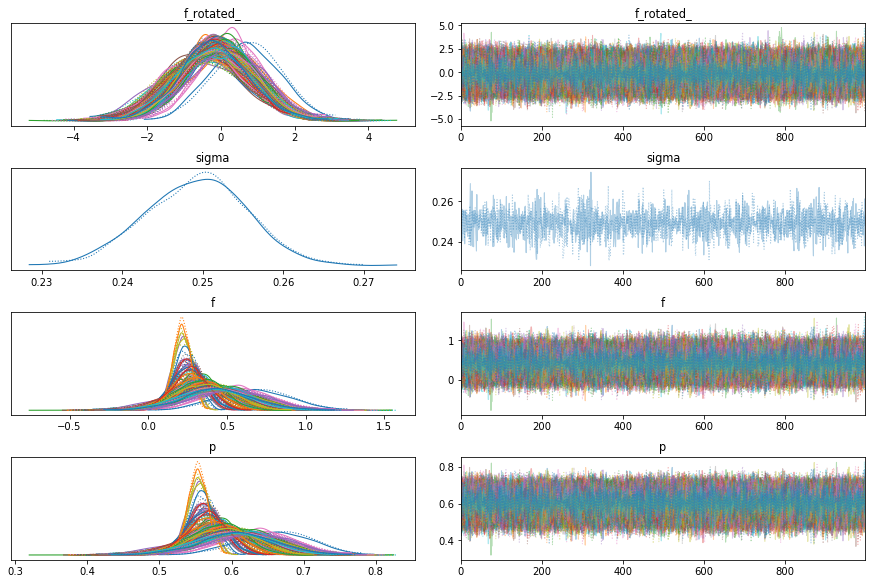

In [32]:
pm.traceplot(gp_trace)

In [33]:
from scipy import stats

#Generate new X for a log-Normal distribution with params mu and CV from snow depth data
mu = 0.40
cv = 0.6
zeta = np.sqrt(np.log(1 + cv**2))
lam = np.log(mu) - (zeta**2)/2
x_new = stats.lognorm.rvs(scale = np.exp(lam),s = zeta, loc = 0, size = 315)
print(x_new.shape)

with gp_model:
    f_pred = gp.conditional("y_pred", x_new.reshape(-1,1))
    y_samples = pm.sample_posterior_predictive(gp_trace, vars=[f_pred], samples = 300)

(315,)


/home/julien/anaconda3/envs/bayes/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


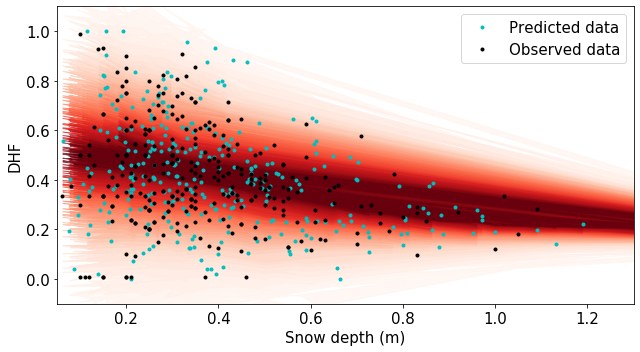

In [45]:
from pymc3.gp.util import plot_gp_dist
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fig = plt.figure(figsize=(9,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], x_new, plot_samples=False);

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
y_predict = y_samples["y_pred"][180, :]
y_predict = np.where(y_predict >= 0, y_predict, 0)
y_predict = np.where(y_predict <= 1.0, y_predict, 1)
plt.plot(x_new, y_predict, "co", ms=3, label="Predicted data");
# plot original data and true function
plt.plot(df.x.values, df.y_DH.values, 'ok', ms=3, alpha=1.0, label="Observed data");
plt.xlabel('Snow depth (m)', size =15)
plt.ylabel('DHF', size = 15)
plt.ylim(-0.1,1.1)
plt.legend(prop={'size': 15})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlim(0.05,1.3)
fig.savefig("/home/julien/OneDrive/Doctorat/spatialVariability/article/fig/fig_cryo/fig06.png", dpi = 300)